In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [4]:
raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)


original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,oldpeak
0,63,1,1,145,233,1,2,150,0,3,0,6,2.3
1,67,1,4,160,286,0,2,108,1,2,3,3,1.5
2,67,1,4,120,229,0,2,129,1,2,2,7,2.6
3,37,1,3,130,250,0,0,187,0,3,0,3,3.5
4,41,0,2,130,204,0,2,172,0,1,0,3,1.4


In [5]:
cleveland_data = pd.read_csv("data/heart.csv")
cleveland_data["target"].value_counts()
    
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()
# cleveland_data.dtypes

1    165
0    138
Name: target, dtype: int64

In [33]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 15, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [34]:
## Need to define a scaling function that ignores categorical values...?

In [35]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                700       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 3,352
Trainable params: 3,352
Non-trainable params: 0
_________________________________________________________________


In [36]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [37]:
# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.614, Acc:0.8837
Prediction Accuracy
28/28 [==============================] - 0s 2ms/step
Scores on data set: loss=0.535 accuracy=0.9286
Fold Correct: 26
Running worker: 1
Fold: 1 -> Loss:0.648, Acc:0.8566
Prediction Accuracy
28/28 [==============================] - 0s 22us/step
Scores on data set: loss=0.623 accuracy=0.8571
Fold Correct: 24
Running worker: 2
Fold: 2 -> Loss:0.609, Acc:0.8876
Prediction Accuracy
28/28 [==============================] - 0s 16us/step
Scores on data set: loss=0.802 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.611, Acc:0.8605
Prediction Accuracy
27/27 [==============================] - 0s 23us/step
Scores on data set: loss=0.865 accuracy=0.7407
Fold Correct: 20
Running worker: 4
Fold: 4 -> Loss:0.581, Acc:0.8769
Prediction Accuracy
26/26 [==============================] - 0s 26us/step
Scores on data set: loss=1.226 accuracy=0.6538
Fold Correct: 17
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.84027778 0.15972222]
 [0.18699187 0.81300813]]


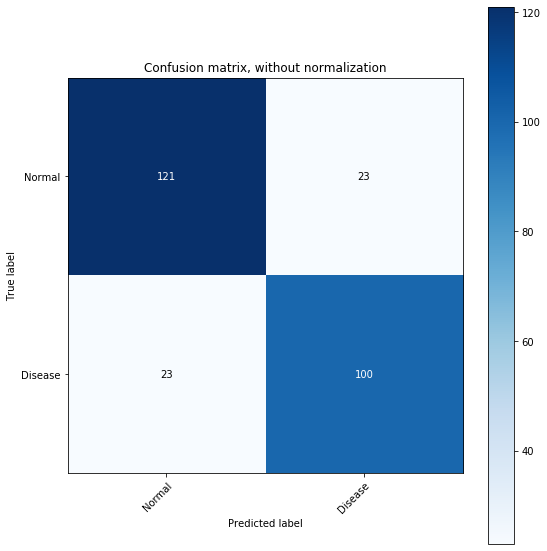

In [38]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [41]:
# min_cluster_sizes=range(10,17,1)
pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.353768,0.353768
"(13, 12)",2,0.0,0.353768,0.353768
"(13, 13)",2,0.0,0.353768,0.353768
"(14, 12)",2,0.0,0.353768,0.353768
"(14, 13)",2,0.0,0.353768,0.353768
"(14, 14)",2,0.0,0.353768,0.353768
"(15, 12)",2,0.0,0.353768,0.353768
"(15, 13)",2,0.0,0.353768,0.353768
"(15, 14)",2,0.0,0.353768,0.353768
"(15, 15)",2,0.0,0.353768,0.353768


In [42]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    60
1    40
dtype: int64

In [43]:
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!


In [44]:
pd.Series(cluster_labels).value_counts()

0    10
dtype: int64

## Plotting Testing LRP

In [45]:

training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [46]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=15,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

# Comparing Subclusters to Original Data

In [47]:
y_train.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [48]:
original_y = original_labels[y_train.index]
original_y.head()

101    0
214    0
206    1
241    0
27     0
Name: target, dtype: int64

In [49]:
y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

122    1
24     1
137    1
184    0
260    0
Name: target, dtype: int64

In [50]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]

In [53]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-vs-original.html')

## Calculating Entropy

In [39]:
relevance_embedding = embedding
relevance_embedding.shape

(96, 3)

In [40]:
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
    
nsamples = len(relevance_embedding)

nbins  = 100
# xedges = np.linspace(0,1,nbins+1)
# yedges = np.linspace(0,1,nbins+1)
# zedges = np.linspace(0,1,nbins+1)

# axes_ = [x.ravel() for x in np.meshgrid(xedges,yedges,zedges)]

# grid = np.array([x for x in zip(*axes_)])

grid, edges = np.histogramdd(relevance_embedding, bins=nbins)
densities = (grid/nsamples).flatten()

In [41]:
entropy(densities)

4.535467058944506

In [42]:
# kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(relevance_embedding)
# train_densities = kde.score_samples(relevance_embedding)
# densities = np.exp(kde.score_samples(grid))

# # pd.DataFrame(densities).plot(kind="bar")

# # pd.DataFrame(densities[densities > 0]).plot()
# emb3d["marker"]["color"] = train_densities
# emb3d["marker"]["showscale"]=True
# emb3d["marker"]["colorscale"]="Reds"

# data=[emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-densities.html')

# entropy(densities)

# %%time

# lowest_bic = np.infty
# bic = []
# n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']
# for cv_type in cv_types:
#     for n_components in n_components_range:
#         # Fit a Gaussian mixture with EM
#         gmm = GaussianMixture(n_components=n_components,
#                               covariance_type=cv_type)
#         gmm.fit(relevance_embedding)
#         bic.append(gmm.bic(relevance_embedding))
#         if bic[-1] < lowest_bic:
#             lowest_bic = bic[-1]
#             best_gmm = gmm
# best_gmm.fit(relevance_embedding)

# gmm_training_densities = np.exp(best_gmm.score_samples(relevance_embedding))
# gmm_densities = np.exp(best_gmm.score_samples(grid))

# emb3d["marker"]["color"] = gmm_training_densities
# emb3d["marker"]["showscale"]=True
# emb3d["marker"]["colorscale"]="Reds"

# data=[emb3d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='lrp-densities.html')
# print("Entropy:", entropy(gmm_densities))

In [30]:
df = pd.read_csv("data/original_heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [47]:
print("Original Distribution:\n",df["target"].value_counts(), sep="")
original_labels = df["target"]
training_labels = df["target"].copy()
training_labels[training_labels > 0] = 1
print("Combined:\n",training_labels.value_counts(), sep="")

Original Distribution:
0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64
Combined:
0    164
1    139
Name: target, dtype: int64


In [46]:
training_labels.value_counts()

0    164
1    139
Name: target, dtype: int64